# Project Data Wrangling & SQL

In [140]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from matplotlib.gridspec import GridSpec
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_timedelta64_dtype as is_timedelta

# Import module
from wrangling import kde_multiple_plot, boxplot_multiple_plot, mapping_translation, subplots_dayname_timeday, check_missing_value

# Setting dataframe and plot style
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

In [141]:
# creating file path
dbfile = 'dataset/olist.db'

# Create a SQL connection to our SQLite database
conn = sqlite3.connect(dbfile)

# creating cursor
curr = conn.cursor()

# reading all table names
table_list = [a for a in curr.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

[('olist_order_customer_dataset',), ('olist_order_dataset',), ('olist_order_reviews_dataset',), ('olist_order_payments_dataset',), ('olist_order_items_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('olist_geolocation_dataset',), ('product_category_name_translation',)]


## 1. Perusahaan menginginkan informasi pertumbuhan pemesanan produk

### Akses Dataset

In [142]:
# Create a SQL Query that will be executed by the sqlite3 module
querry_1 = """
SELECT
    *
FROM olist_order_dataset AS ood
LEFT JOIN olist_order_customer_dataset AS oocd
    ON ood.customer_id = oocd.customer_id
"""

In [143]:
# Create dataframe from querry and parses the date on multiple columns
data_orders = pd.read_sql(querry_1, conn, parse_dates=[
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
    ])

In [144]:
# Show dataframe info
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          99441 non-null  int64         
 1   order_id                       99441 non-null  object        
 2   customer_id                    99441 non-null  object        
 3   order_status                   99441 non-null  object        
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99281 non-null  datetime64[ns]
 6   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 7   order_delivered_customer_date  96476 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 9   index                          99441 non-null  int64         
 10  customer_id                    99441 non-null  object        
 11  customer_unique

### Missing Value

#### Check Missing Value

In [145]:
# Check missing value menggunakan module check_missing_value
check_missing_value(data_orders)

,NaN_count,NaN_percentage
order_delivered_customer_date,2965,0.029817
order_delivered_carrier_date,1783,0.017930
order_approved_at,160,0.001609


#### Handling Missing Value

Pada tabel di atas terdapat beberapa *missing value*, diantaranya adalah `order_delivered_customer_date`, `order_delivered_carrier_date`, dan `order_approved_at`. Oleh karena itu akan dilihat distribusi `order_statusnya`, tetapi pertama akan melihat *unique value* yang terdapat pada kolom `order_status`

In [146]:
# Melihat unique value pada kolom order status
data_orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Setelah mengetahui *unique value* dari kolom `order_status`, maka akan plot menggunakan `countplot` untuk mengetahui distribusi dan persentasenya masing-masing

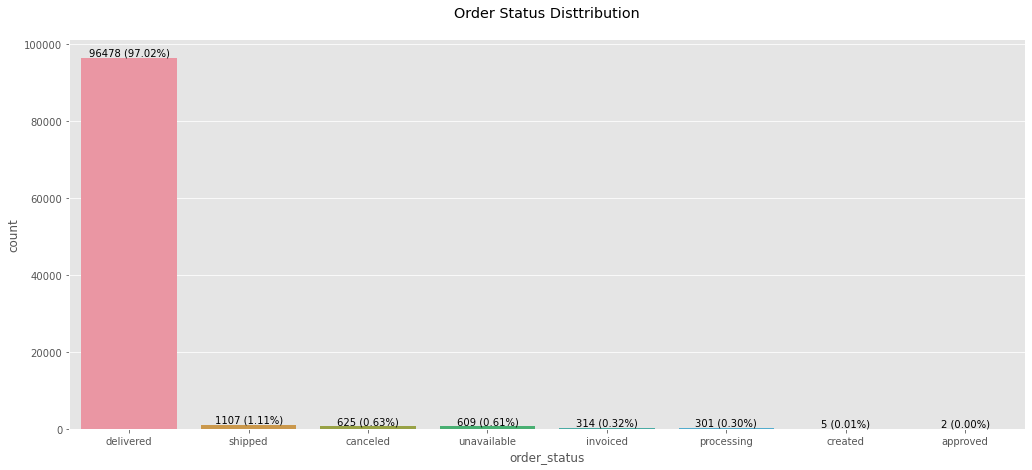

In [147]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.tight_layout()
# Plot countplot in ax
sns.countplot(
    data=data_orders, 
    x='order_status', 
    ax=ax,
    order=data_orders['order_status'].value_counts(ascending=False).index
)

# Create Absolute Value for labels
abs_values = data_orders['order_status'].value_counts(ascending=False)
# Create Relative Value for labels
rel_values = data_orders['order_status'].value_counts(ascending=False, normalize=True)
# Labels Formatting
lbls = [f'{p[0]} ({p[1]:.2%})' for p in zip(abs_values, rel_values)]
# Assign label into plot
ax.bar_label(container=ax.containers[0], labels=lbls)

plt.title("Order Status Disttribution\n")
plt.show()

Setelah mengetahui distribusinya, maka sekarang kan melihat data apa saja yang memiliki nilai *unavailable* dan *canceled* pada kolom `order_status`. Selanjutnya data tersebut akan dibuang karena tujuan dari analisis ini adalah untuk mengetahui *growth* order dari *e-commerce*, maka yang diamati hanya order-order yang berhasil atau sedang proses saja.

In [148]:
# Filter data
data_orders = data_orders.loc[
    ~(((data_orders.order_delivered_carrier_date.isnull()) | (data_orders.order_delivered_customer_date.isnull())) & 
      ((data_orders.order_status == 'canceled') | (data_orders.order_status == 'unavailable')))].copy()

Cek kembali missing value pada dataset

In [149]:
# Check missing value menggunakan module check_missing_value
check_missing_value(data_orders)

,NaN_count,NaN_percentage
order_delivered_customer_date,1737,0.017686
order_delivered_carrier_date,624,0.006354
order_approved_at,19,0.000193


Jumlah *null value* sudah berkurang tetapi masih ada, hal tersebut terjadi karena masih terdapat order yang masih *on-going*. Maka kolom `order_approved_at`, `order_delivered_carrier_date`, dan `order_delivered_customer_date` belum memiliki waktu dan tanggal serta beberapa kolom yang tidak dibutuhkan akan dihapus.

In [150]:
# Show index every column
column_data_orders = [column for column in enumerate(data_orders.columns)]

# Print column_data_orders 
print(column_data_orders)

[(0, 'index'), (1, 'order_id'), (2, 'customer_id'), (3, 'order_status'), (4, 'order_purchase_timestamp'), (5, 'order_approved_at'), (6, 'order_delivered_carrier_date'), (7, 'order_delivered_customer_date'), (8, 'order_estimated_delivery_date'), (9, 'index'), (10, 'customer_id'), (11, 'customer_unique_id'), (12, 'customer_zip_code_prefix'), (13, 'customer_city'), (14, 'customer_state')]


In [151]:
# Menghapus kolom index, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, index
data_orders.drop(data_orders.columns[np.r_[0,5:8,9]], axis=1, inplace=True)
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-15,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-26,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


## Duplicate

### Check Duplicate columns

Untuk melihat kolom duplikat dapat dilakukan dengan menggunakan *method* `duplicated()`, akan tetapi *method* `duplicated()` hanya bekerja pada `axis=0` maka dataframe-nya perlu dirubah bentuk menggunakan *attribute* *Transpose* terlebih dahulu.

In [152]:
# Check duplicated column
data_orders.T.duplicated(keep=False)

order_id                         False
customer_id                       True
order_status                     False
order_purchase_timestamp         False
order_estimated_delivery_date    False
customer_id                       True
customer_unique_id               False
customer_zip_code_prefix         False
customer_city                    False
customer_state                   False
dtype: bool

#### Handling Duplicate Columns

Pada data di atas dapat dilihat jika terdapat duplikat kolom, yaitu: `customer_id` dengan `customer_id`. Oleh karena itu akan menghapus salah satu kolom menggunakan *method* `drop_duplicated(keep='first')`. Sama seperti *method* `duplicated()`, *method* `drop_duplicated()` pun hanya bekerja pada `axis=0` saja. Maka *dataframe*-nya perlu diubah bentuk terlebih dahulu dengan menggunakan *attribute Transpose* lalu mengembalikan bentuk *dataframe* seperti semua menggunakan *attribute Transpose* kembali.

In [153]:
# Drop duplicate columns
data_orders = data_orders.T.drop_duplicates(keep='first').T

In [154]:
# Show info 
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98213 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98213 non-null  object        
 1   customer_id                    98213 non-null  object        
 2   order_status                   98213 non-null  object        
 3   order_purchase_timestamp       98213 non-null  datetime64[ns]
 4   order_estimated_delivery_date  98213 non-null  datetime64[ns]
 5   customer_unique_id             98213 non-null  object        
 6   customer_zip_code_prefix       98213 non-null  object        
 7   customer_city                  98213 non-null  object        
 8   customer_state                 98213 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 9.5+ MB


### Analisa Data

#### Mengekstrak atribut dari kolom order_purchase_timestamp

Memebuat beberapa kolom baru menggunakan `apply` function, tujuan pembuatan kolom-kolom baru ini untuk memberi gambaran yang lebih detail mengenai tanggal dan waktu.

In [155]:
# Extracting attributes for purchase date - Year and Month
data_orders['order_purchase_year'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.year)
data_orders['order_purchase_month'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.month)
data_orders['order_purchase_month_name'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
data_orders['order_purchase_year_month'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
data_orders['order_purchase_date'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase
data_orders['order_purchase_quarter'] = pd.PeriodIndex(data_orders['order_purchase_timestamp'].dt.date, freq='Q')
data_orders['order_purchase_quarter'] = data_orders['order_purchase_quarter'].apply(lambda x: x.strftime('%F-Q%q'))

# Extracting attributes for purchase date - Day and Day of Week
data_orders['order_purchase_day'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.day)
data_orders['order_purchase_dayofweek'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
data_orders['order_purchase_dayofweek_name'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
data_orders['order_purchase_hour'] = data_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
data_orders['order_purchase_time_day'] = pd.cut(data_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_quarter,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2017-Q4,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,2018-Q3,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,2018-Q3,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,2017-Q4,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,2018-Q1,13,1,Tue,21,Night


#### Order trends quarterly

Membuat `DataFrame` baru menggunakan *method* `groupby` untuk mengetahui tren pemesanan produk setiap tiga bulan.

In [156]:
# Group by order_purchase_quarter and assign into dataframe
data_order_quarterly = pd.DataFrame(data_orders.groupby("order_purchase_quarter")['order_id'].count())

# Reset index
data_order_quarterly.reset_index(inplace=True)

# Rename column order_id to n_orders
data_order_quarterly.rename(columns={'order_id':'n_orders'}, inplace=True)

Setelah melakukan `groupby` akan ditambahkan kolom baru yang berisi perbedaan nilai tiap kuarternya beserta fluktuasi naik turunnya dalam bentuk persentase.

In [157]:
# Create new column percentage_total_orders
data_order_quarterly = data_order_quarterly.assign(percentage_total_orders = lambda x: round(x['n_orders']/x['n_orders'].sum(), 3))

# Create new column n_orders_diff
data_order_quarterly['n_orders_diff'] = data_order_quarterly['n_orders'].diff().fillna(0).astype(int)

# Create new column n_orders_pct_change
data_order_quarterly['n_orders_pct_change'] = data_order_quarterly['n_orders'].pct_change().fillna(0).round(2)

Tabel akhirnya akan berbentuk seperti ini:

In [158]:
data_order_quarterly.head(10)

,order_purchase_quarter,n_orders,percentage_total_orders,n_orders_diff,n_orders_pct_change
0,2016-Q3,2,0.000,0,0.00
1,2016-Q4,299,0.003,297,148.50
2,2017-Q1,5122,0.052,4823,16.13
3,2017-Q2,9222,0.094,4100,0.80
4,2017-Q3,12445,0.127,3223,0.35
5,2017-Q4,17590,0.179,5145,0.41
6,2018-Q1,20981,0.214,3391,0.19
7,2018-Q2,19897,0.203,-1084,-0.05
8,2018-Q3,12655,0.129,-7242,-0.36


In [159]:
# save to csv
data_order_quarterly.to_csv("dataset\data_order_quarterly.csv", index=False)

#### Total of Orders by Day of Week

Untuk memperdalam analisa data di atas akan di-*breakdown* lagi menjadi data pemesanan produk berdasarkan hari pemesanannnya. Untuk mengetahui hari apa saja user aktif dan memesan.

In [160]:
# Group by order_purchase_dayofweek_name and assign into dataframe with order index from monday to sunday
data_orders_dayofweek = pd.DataFrame(data_orders.groupby("order_purchase_dayofweek_name")['order_id'].count(), index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Reset index
data_orders_dayofweek.reset_index(inplace=True)

# Rename column name
data_orders_dayofweek.rename(columns={'index':'order_purchase_dayofweek_name', 'order_id':'n_orders'}, inplace=True)

# Create new column percentage
data_orders_dayofweek = data_orders_dayofweek.assign(percentage=lambda x: x['n_orders']/ x['n_orders'].sum())
data_orders_dayofweek['percentage'] = data_orders_dayofweek['percentage'].round(3)
data_orders_dayofweek.head(10)

,order_purchase_dayofweek_name,n_orders,percentage
0,Mon,15981,0.163
1,Tue,15760,0.160
2,Wed,15353,0.156
3,Thu,14571,0.148
4,Fri,13950,0.142
5,Sat,10765,0.110
6,Sun,11833,0.120


In [161]:
# Save data to csv
data_orders_dayofweek.to_csv("dataset/data_order_purchase_dayofweek_name.csv")

#### Total of Orders by Time Day

Untuk memperdalam analisa data di atas akan di-*breakdown* lagi menjadi data pemesanan produk berdasarkan daktu pemesannannya. Untuk mengetahui waktu kapan saja user aktif dan memesan.

In [162]:
# Group by order_purchase_time_day and assign into dataframe
data_orders_timeday = pd.DataFrame(data_orders.groupby('order_purchase_time_day')['order_id'].count())

# Reset index
data_orders_timeday.reset_index(inplace=True)

# Rename column name
data_orders_timeday.rename(columns={'order_id':'n_orders'}, inplace=True)

# Create new column percentage
data_orders_timeday = data_orders_timeday.assign(percentage=lambda x: x['n_orders']/ x['n_orders'].sum())
data_orders_timeday['percentage'] = data_orders_timeday['percentage'].round(3)
data_orders_timeday.head()

,order_purchase_time_day,n_orders,percentage
0,Dawn,5170,0.053
1,Morning,27368,0.279
2,Afternoon,37669,0.384
3,Night,28006,0.285


#### Most ordering hours

Untuk memperdalam analisa data di atas akan di-*breakdown* lagi menjadi data pemesanan produk berdasarkan jam pemesanannnya. Untuk mengetahui jam berapa saja kah user aktif dan memesan.

In [163]:
purchase_count = data_orders.groupby(['order_purchase_dayofweek_name', 'order_purchase_hour']).count()['order_id'].unstack()

In [164]:
purchase_count

order_purchase_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_purchase_dayofweek_name,,,,,,,,,,,,,,,,,,,,,,,,
Fri,418,210,70,48,40,35,96,204,493,758,942,983,843,989,951,969,960,807,716,772,730,714,695,507
Mon,322,134,64,36,21,22,65,159,475,765,1020,1068,961,1013,1082,1065,1076,974,915,934,1016,1104,982,708
Sat,312,171,66,42,25,23,52,104,248,426,648,701,681,702,670,716,688,694,707,746,724,651,543,425
Sun,261,140,68,43,27,27,33,105,203,343,524,715,669,714,676,708,706,792,888,892,956,876,864,603
Thu,354,167,74,39,31,28,83,217,497,750,970,945,963,968,968,916,1066,893,776,814,829,832,850,541
Tue,304,157,80,28,28,24,71,219,515,853,950,1040,889,1036,1106,1026,1074,956,868,909,970,1017,955,685
Wed,392,175,81,31,33,26,93,210,508,817,1029,1046,912,1009,1039,971,1024,958,837,833,892,953,872,612


#### Plot Data

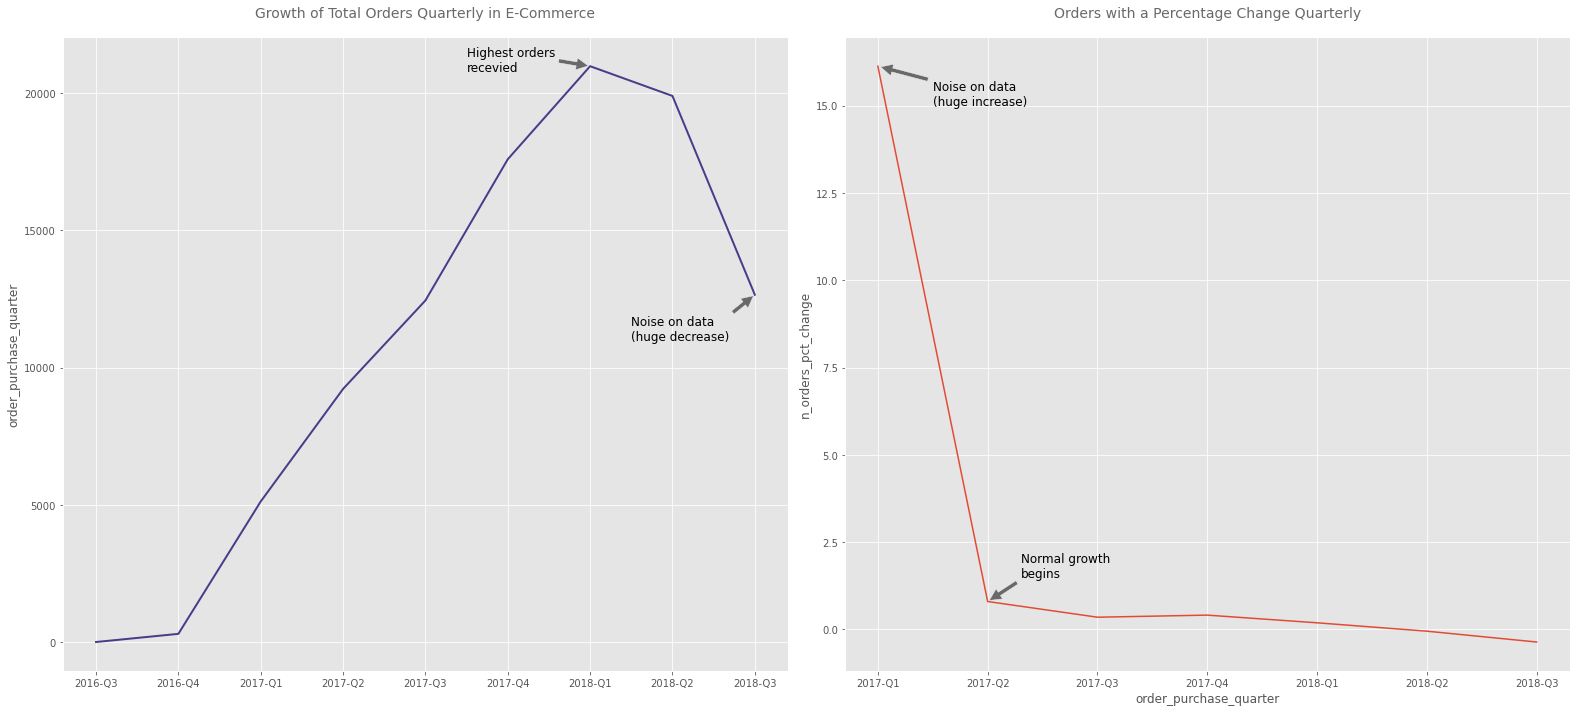

In [165]:
# Lineplot - Growth of e-commerce orders along time 
fig, ax = plt.subplots(1,2, figsize=(22, 10))
sns.lineplot(
    data=data_orders['order_purchase_quarter'].value_counts().sort_index(), 
    ax=ax[0], 
    color='darkslateblue', linewidth=2
)
# Create annotate
ax[0].annotate(
    'Highest orders\nrecevied', xy =(6, 20981),
    xytext =(4.5, 20800), 
    fontsize=12,
    arrowprops = dict(facecolor ='dimgrey', 
                      shrink = 0.05)   
)
# Create annotate
ax[0].annotate(
    'Noise on data \n(huge decrease)', xy =(8, 12655),
    xytext =(6.5, 11000),
    fontsize=12,
    arrowprops = dict(facecolor ='dimgrey', 
                      shrink = 0.05)   
)
# Set title 
ax[0].set_title('Growth of Total Orders Quarterly in E-Commerce', size=14, color='dimgrey', pad=20)

# Lineplot - Percentace change orders along time
sns.lineplot(
    data=data_order_quarterly[2:], 
    x='order_purchase_quarter', 
    y='n_orders_pct_change', 
    ax=ax[1]
)
# Create annotate
ax[1].annotate(
    'Noise on data \n(huge increase)', xy =(0, 16.13),
    xytext =(0.5, 15), 
    fontsize=12,
    arrowprops = dict(facecolor ='dimgrey', 
                      shrink = 0.05)   
)
# Create annotate
ax[1].annotate(
    'Normal growth\nbegins', xy =(1, 0.8),
    xytext =(1.3, 1.5), 
    fontsize=12,
    arrowprops = dict(facecolor ='dimgrey', 
                      shrink = 0.05) 
)
# Set title
ax[1].set_title("Orders with a Percentage Change Quarterly", size=14, color='dimgrey', pad=20)

fig.tight_layout()
plt.show()

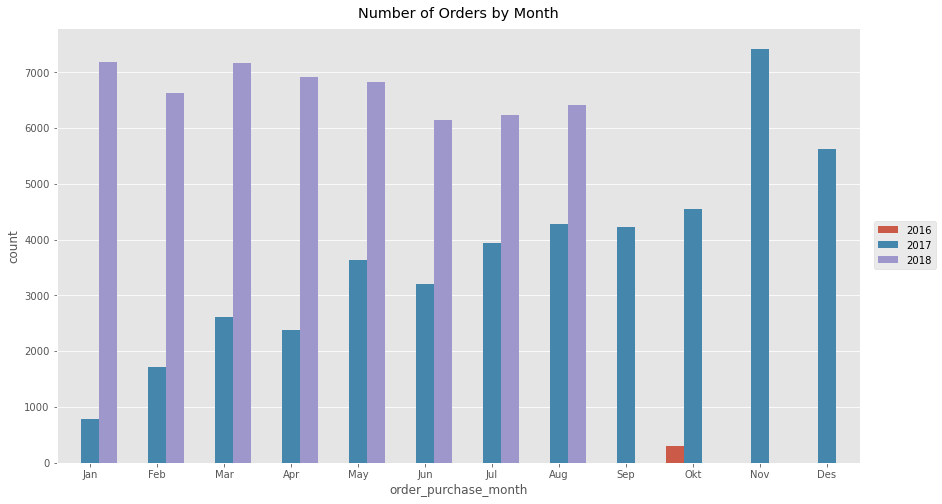

In [166]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.countplot(data=data_orders, x='order_purchase_month', hue='order_purchase_year')

# Create weekday label in order
weekday_label = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Des"]

# Assign weekday label using xticklabels
ax.set_xticklabels(weekday_label)

# Add a title
ax.set_title("Number of Orders by Month", pad=10)

# Add a legend
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()


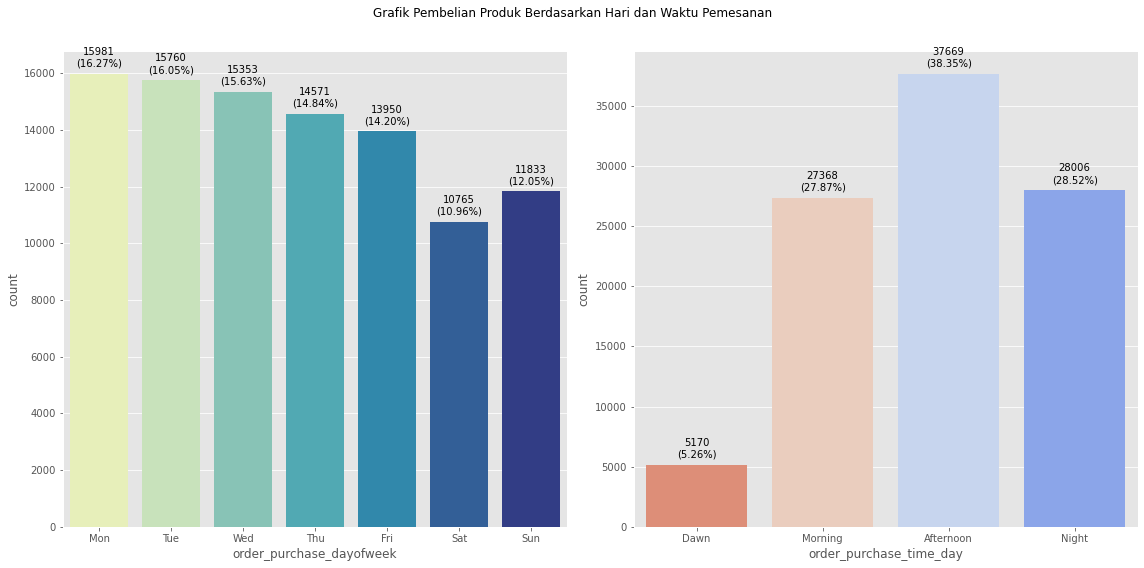

In [167]:
# Plotting count plot using subplots_dayname_timeday module

subplots_dayname_timeday(data_orders, 'order_purchase_dayofweek', 'order_purchase_time_day', 'Grafik Pembelian Produk Berdasarkan Hari dan Waktu Pemesanan')

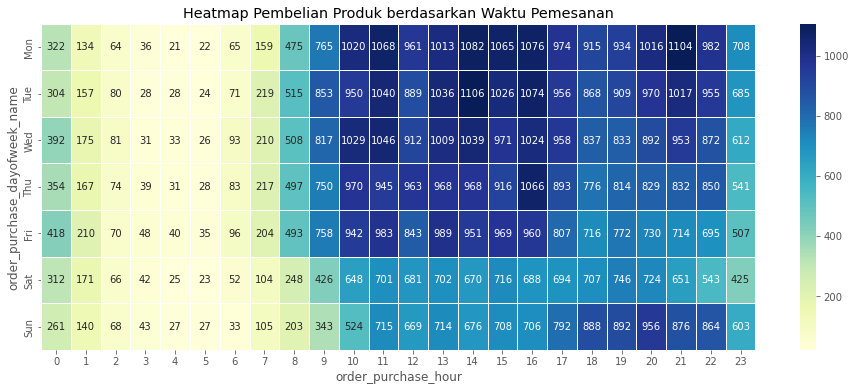

In [168]:
# Plotting heatmap total orders by hour
plt.figure(figsize=(16,6))
sns.heatmap(purchase_count.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
            cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title("Heatmap Pembelian Produk berdasarkan Waktu Pemesanan")
plt.show()

In [169]:
# fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# # Axis definition
# gs = GridSpec(2, 2, figure=fig)
# ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[1, 1])

# # Axes 1
# # Lineplot - Growth of e-commerce orders along time 
# sns.lineplot(
#     data=data_orders['order_purchase_quarter'].value_counts().sort_index(), 
#     ax=ax1, 
#     color='darkslateblue', 
#     linewidth=3
# )

# # Set title of axes 1   
# ax1.set_title('Growth of Total Orders Quarterly in E-Commerce', size=14, color='dimgrey', pad=20)
# plt.show()

# # Axes 2
# # Countplot - Total of orders by day of week
# sns.countplot(
#     data=data_orders, 
#     x='order_purchase_dayofweek_name', 
#     ax=ax2,
#     palette='YlGnBu'
# )

# # Create Absolute Value for labels
# abs_values_dayofweek = data_orders['order_purchase_dayofweek_name'].value_counts(ascending=False)
# # Create Relative Value for labels
# rel_values_dayofweek = data_orders['order_purchase_dayofweek_name'].value_counts(ascending=False, normalize=True)
# # Labels Formatting
# lbls = [f'{p[0]}\n({p[1]:.2%})' for p in zip(abs_values_dayofweek, rel_values_dayofweek)]

# # Assign label into plot
# ax2.bar_label(container=ax2.containers[0], labels=lbls, padding=5)
# # Ordering xtick label
# weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# # Set xtick label
# ax2.set_xticklabels(weekday_label)

# # Set title of axes 2
# ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# # Axes 3
# # Countplot - Total of orders by time of the day
# sns.countplot(
#     data=data_orders, 
#     x='order_purchase_time_day', 
#     ax=ax3,
#     palette='coolwarm_r'
# )

# # Create Absolute Value for labels
# abs_values_time_day = data_orders['order_purchase_time_day'].value_counts(ascending=False)
# # Create Relative Value for labels
# rel_values_time_day = data_orders['order_purchase_time_day'].value_counts(ascending=False, normalize=True)
# # Labels Formatting
# lbls = [f'{p[0]}\n({p[1]:.2%})' for p in zip(abs_values_time_day, rel_values_time_day)]

# # Assign label into axes 3
# ax3.bar_label(container=ax3.containers[0], labels=lbls, padding=5)
# # Set title axes 3
# ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

# plt.tight_layout()
# plt.show()

## Delivery Time

Pada *case* kali ini ingin mengetahui tentang waktu *delivery*

### Akses Dataset

In [170]:
# SQL querry
querry_2 = """
SELECT 
    *
FROM olist_order_dataset AS ood
LEFT JOIN olist_order_items_dataset AS ooid
    ON ood.order_id = ooid.order_id
JOIN olist_products_dataset AS opd
    ON ooid.product_id = opd.product_id
WHERE ood.order_status = 'delivered';
"""

In [171]:
# Load querry using pandas read_sql
data_delivery = pd.read_sql(querry_2, conn, parse_dates=[
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date',
    'shipping_limit_date'
])

In [172]:
# Show 10 data from data_delivery
data_delivery.head(10)

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,100785,e481f51cbdc54678b7cc49136f2d6af7,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2349,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,36896,53cdb2fc8bc7dce0b6741e2150273451,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,20550,595fac2a385ac33a80bd5114aec74eb8,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,31504,47770eb9100c2d0c44946d9cf07ec65d,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,12228,aa4383b373c6aca5d8797843e5594415,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,65021,949d5b44dbf5de918fe9c16f97b45f8a,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,29925,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,76043,ad21c59c0840e6cb83a9ceb5573f8159,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,11900,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0
5,5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,72040,a4591c265e18cb1dcee52889e2d8acc3,1,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36,18705,060cb19345d90064d1015407193c233d,automotivo,49.0,608.0,1.0,7150.0,65.0,10.0,65.0
6,7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,44487,6514b8ad8028c9f2cc2374ded245783f,1,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,2017-05-22 13:22:11,59.99,15.17,9304,4520766ec412348b8d4caa5e8a18c464,automotivo,59.0,956.0,1.0,50.0,16.0,16.0,17.0
7,8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,52193,76c6e866289321a7c93b82b54852dc33,1,ac1789e492dcd698c5c10b97a671243a,63b9ae557efed31d1f7687917d248a8d,2017-01-27 18:29:09,19.90,16.05,3568,ac1789e492dcd698c5c10b97a671243a,moveis_decoracao,41.0,432.0,2.0,300.0,35.0,35.0,15.0
8,9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,101632,e69bfb5eb88e0ed6a785585b27e16dbf,1,9a78fb9862b10749a117f7fc3c31f051,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,28725,9a78fb9862b10749a117f7fc3c31f051,moveis_escritorio,45.0,527.0,1.

In [173]:
# Show data info
data_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          110197 non-null  int64         
 1   order_id                       110197 non-null  object        
 2   customer_id                    110197 non-null  object        
 3   order_status                   110197 non-null  object        
 4   order_purchase_timestamp       110197 non-null  datetime64[ns]
 5   order_approved_at              110182 non-null  datetime64[ns]
 6   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 7   order_delivered_customer_date  110189 non-null  datetime64[ns]
 8   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 9   index                          110197 non-null  int64         
 10  order_id                       110197 non-null  object        
 11  

### Duplicated

#### Check Duplicated

Untuk melihat kolom duplikat dapat dilakukan dengan menggunakan *method* `duplicated()`, akan tetapi *method* `duplicated()` hanya bekerja pada `axis=0` maka dataframe-nya perlu dirubah bentuk menggunakan *attribute* *Transpose* terlebih dahulu.

In [174]:
# Check duplicated column
data_delivery.T.duplicated(keep=False)

index                            False
order_id                          True
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                False
order_delivered_carrier_date     False
order_delivered_customer_date    False
order_estimated_delivery_date    False
index                            False
order_id                          True
order_item_id                    False
product_id                        True
seller_id                        False
shipping_limit_date              False
price                            False
freight_value                    False
index                            False
product_id                        True
product_category_name            False
product_name_lenght              False
product_description_lenght       False
product_photos_qty               False
product_weight_g                 False
product_length_cm                False
product_height_cm        

#### Handling Duplicate Columns

Pada data di atas dapat dilihat jika terdapat duplikat kolom, yaitu: `order_id` dan `product_id`.

In [175]:
data_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          110197 non-null  int64         
 1   order_id                       110197 non-null  object        
 2   customer_id                    110197 non-null  object        
 3   order_status                   110197 non-null  object        
 4   order_purchase_timestamp       110197 non-null  datetime64[ns]
 5   order_approved_at              110182 non-null  datetime64[ns]
 6   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 7   order_delivered_customer_date  110189 non-null  datetime64[ns]
 8   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 9   index                          110197 non-null  int64         
 10  order_id                       110197 non-null  object        
 11  

Pertama-tama akan memisahkan kolom yang duplikat terlebih dahulu, hal tersebut disebabkan karena jika melakukan *double transpose* maka tipe data selain `datetime` akan berubah menjadi `object`. Maka proses `drop_duplicated()` akan dilakukan secara terpisah, dengan cara `drop` terlebih dahulu kolom yang duplikat dan akan melakukan *method* `concat` untuk menggabungkan kembali datanya.

In [176]:
# Filter duplicated columns
data_delivery_duplicated =  data_delivery.iloc[:, [1, 10, 12, 18]].copy()
print(data_delivery_duplicated)

                                order_id                          order_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  e481f51cbdc54678b7cc49136f2d6af7   
1       53cdb2fc8bc7dce0b6741e2150273451  53cdb2fc8bc7dce0b6741e2150273451   
2       47770eb9100c2d0c44946d9cf07ec65d  47770eb9100c2d0c44946d9cf07ec65d   
3       949d5b44dbf5de918fe9c16f97b45f8a  949d5b44dbf5de918fe9c16f97b45f8a   
4       ad21c59c0840e6cb83a9ceb5573f8159  ad21c59c0840e6cb83a9ceb5573f8159   
...                                  ...                               ...   
110192  63943bddc261676b46f01ca7ac2f7bd8  63943bddc261676b46f01ca7ac2f7bd8   
110193  83c1379a015df1e13d02aae0204711ab  83c1379a015df1e13d02aae0204711ab   
110194  11c177c8e97725db2631073c19f07b62  11c177c8e97725db2631073c19f07b62   
110195  11c177c8e97725db2631073c19f07b62  11c177c8e97725db2631073c19f07b62   
110196  66dea50a8b16d9b4dee7af250b4be1a5  66dea50a8b16d9b4dee7af250b4be1a5   

                              product_id                       

In [177]:
# Drop duplicate columns
data_delivery_without_duplicated = data_delivery_duplicated.T.drop_duplicates(keep='first').T.copy()

In [178]:
# Drop column index, order_id, product_id
data_delivery.drop(data_delivery.columns[np.r_[0, 1, 12]], axis=1, inplace=True)

In [179]:
# Concat two dataframe
data_delivery = pd.concat([data_delivery_without_duplicated, data_delivery], axis=1)
data_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   product_id                     110197 non-null  object        
 2   customer_id                    110197 non-null  object        
 3   order_status                   110197 non-null  object        
 4   order_purchase_timestamp       110197 non-null  datetime64[ns]
 5   order_approved_at              110182 non-null  datetime64[ns]
 6   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 7   order_delivered_customer_date  110189 non-null  datetime64[ns]
 8   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 9   order_item_id                  110197 non-null  int64         
 10  seller_id                      110197 non-null  object        
 11  

### Filter datatypes

Untuk mempermudah dalam proses analisa, maka kelompokan kolom-kolom pada `DataFrame` berdasarkan tipe datanya. Sehingga nanti bisa langsung filter data berdasarkan tipe datanya.

In [180]:
# int64 columns
int_columns = [data for data in data_delivery.columns if data_delivery.dtypes[data] == np.int64]

# datetime columns
datetime_columns = [data for data in data_delivery.columns if is_datetime(data_delivery[data])]

# float64 columns
float_columns = [data for data in data_delivery.columns if data_delivery.dtypes[data] == np.float64]

# categorical columns
obj_columns = [data for data in data_delivery.columns if data_delivery.dtypes[data] == object]


### Missing Value

In [181]:
# Copy dataframe for back up
data_delivery_handled = data_delivery.copy()

##### Check Missing Value Object Column

In [182]:
# Check missing value using module
check_missing_value(data_delivery_handled[obj_columns])

,NaN_count,NaN_percentage
product_category_name,1537,0.013948


##### Handling Missing Value Object Column

Dalam tipe data objek maka `null value` akan diisi dengan nilai modusnya.

In [183]:
# Impute missing value using fillna method
data_delivery_handled['product_category_name'] = data_delivery_handled.product_category_name.fillna(data_delivery_handled.product_category_name.mode()[0])

##### Handling Missing Value Int64 and Float64 Column

Untuk tipe data `int64` dan `float64` akan dilihat dahulu distribusinya untuk menentukan akan mengisi `null value` menggunakan metode apa.

In [184]:
# Check missing value using module
check_missing_value(data_delivery_handled[int_columns + float_columns])

,NaN_count,NaN_percentage
product_name_lenght,1537,0.013948
product_description_lenght,1537,0.013948
product_photos_qty,1537,0.013948
product_weight_g,18,0.000163
product_length_cm,18,0.000163
product_height_cm,18,0.000163
product_width_cm,18,0.000163


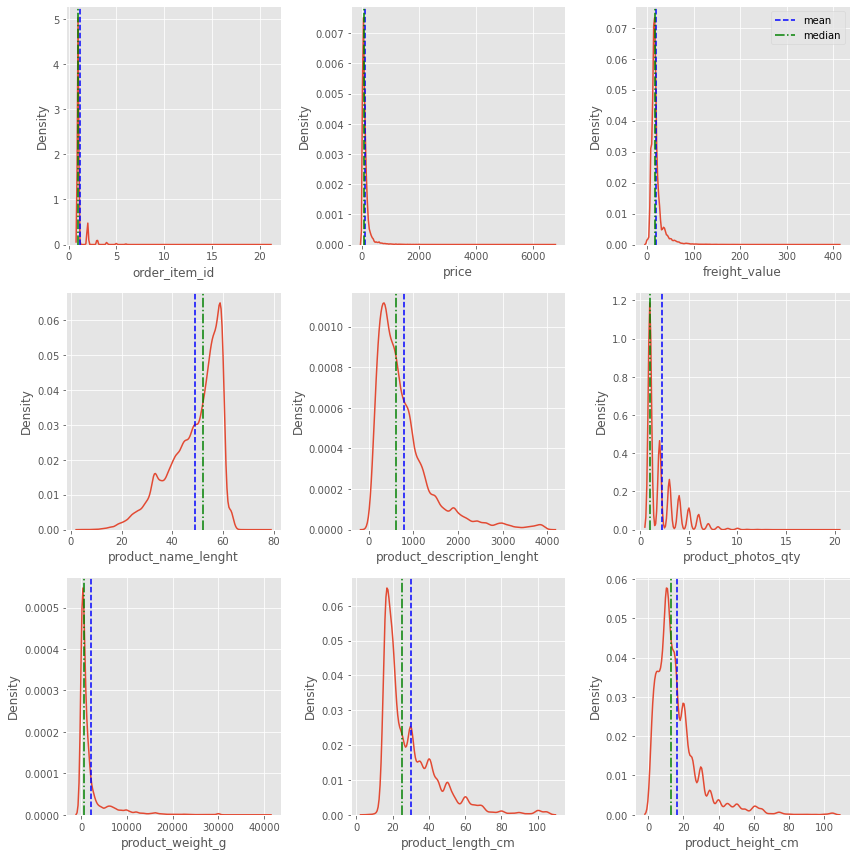

In [185]:
# Plotting KDE plot using module

kde_multiple_plot(data_delivery_handled[int_columns + float_columns], 3, (12,12))

Karena grafik menunjukan jika plotnya skew maka `null value` akan diimpute menggunakan nilai mediannya

In [186]:
# Find median value each column in missing_value_int_float
median_product_name_lenght = data_delivery_handled.product_name_lenght.median()
median_product_description_lenght = data_delivery_handled.product_description_lenght.median()
median_product_photos_qty = data_delivery_handled.product_photos_qty.median()
median_product_weight_g = data_delivery_handled.product_weight_g.median()
median_product_length_cm = data_delivery_handled.product_length_cm.median()
median_product_height_cm = data_delivery_handled.product_height_cm.median()
median_product_width_cm = data_delivery_handled.product_width_cm.median()

# fill null value with median
data_delivery_handled['product_name_lenght'] = data_delivery_handled.product_name_lenght.fillna(median_product_name_lenght)
data_delivery_handled['product_description_lenght'] = data_delivery_handled.product_description_lenght.fillna(median_product_description_lenght)
data_delivery_handled['product_photos_qty'] = data_delivery_handled.product_photos_qty.fillna(median_product_photos_qty)
data_delivery_handled['product_weight_g'] = data_delivery_handled.product_weight_g.fillna(median_product_weight_g)
data_delivery_handled['product_weight_g'] = data_delivery_handled.product_weight_g.fillna(median_product_weight_g)
data_delivery_handled['product_length_cm'] = data_delivery_handled.product_length_cm.fillna(median_product_length_cm)
data_delivery_handled['product_height_cm'] = data_delivery_handled.product_height_cm.fillna(median_product_height_cm)
data_delivery_handled['product_width_cm'] = data_delivery_handled.product_width_cm.fillna(median_product_width_cm)

In [187]:
# Recheck missing value using module
check_missing_value(data_delivery_handled)

,NaN_count,NaN_percentage
order_approved_at,15,0.000136
order_delivered_customer_date,8,0.000073
order_delivered_carrier_date,2,0.000018


Karena masih terdapat beberapa missing value seperti kolom `order_approved_at`, `order_delivered_customer_date`, dan `order_delivered_carrier_date`. Maka baris pada data yang memiliki `null` `value` akan dihapus. Mengapa dihapus? karena konteks yang akan dianalisa adalah waktu dimana produk sampai kepada customer maka nilai `null` pada data tersebut tidak relevan dalam analisa.

In [188]:
# Mencari indeks baris mana saja yang memiliki nilai `null` pada  kolom order_delivered_carrier_date
index_missing_1 = data_delivery_handled[data_delivery_handled['order_delivered_carrier_date'].isna()].index

# Menghapus baris tersebut
data_delivery_handled.drop(index_missing_1, inplace=True)

In [189]:
# Mencari indeks baris mana saja yang memiliki nilai `null` pada  kolom order_delivered_customer_date
index_missing_2 = data_delivery_handled[data_delivery_handled['order_delivered_customer_date'].isna()].index

# Menghapus baris tersebut
data_delivery_handled.drop(index_missing_2, inplace=True)

In [190]:
# Mencari indeks baris mana saja yang memiliki nilai `null` pada  kolom order_approved_at
index_missing_3 = data_delivery_handled[data_delivery_handled['order_approved_at'].isna()].index

# Menghapus baris tersebut
data_delivery_handled.drop(index_missing_3, inplace=True)

In [191]:
# Recheck missing value using module
check_missing_value(data_delivery_handled)

,NaN_count,NaN_percentage


### Outliers

#### Check Outliers

Untuk mencari outliers dari suatu data dapat melihat nilai quantile 1, quantile 3 serta IQR nya. Untuk mempermudah datanya bisa diplotting menggunakan boxplot.

In [192]:
# Merge int_columns and float_columns into variable
colnames = int_columns + float_columns

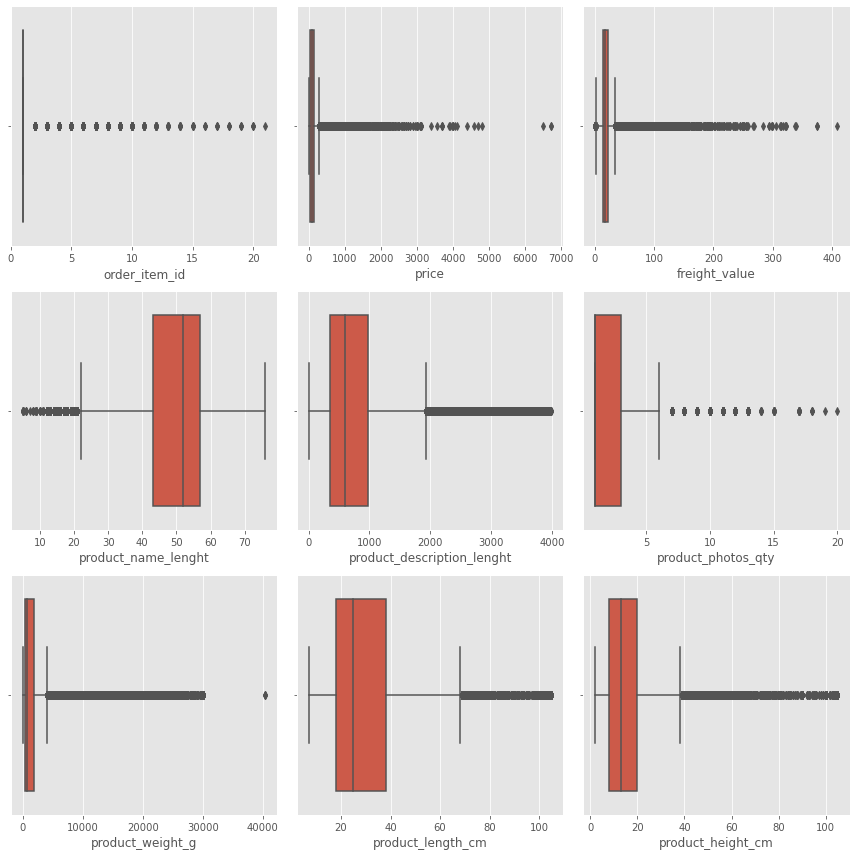

In [193]:
# Plotting boxplot using module
boxplot_multiple_plot(data_delivery_handled[colnames], 3, (12,12))

##### Handling Outliers

In [194]:
# mengiport method copy
import copy

# Mengcopy data original
data_delivery_capped = copy.deepcopy(data_delivery_handled)

In [195]:
# membuat fungsi untuk filter oulier
def capping_outlier(col):
    
    # Mendefinisikan batas atas dan bawah outlier
    lwr_limit = data_delivery_capped[col].quantile(0.03)
    upr_limit = data_delivery_capped[col].quantile(0.97)

    print(str(col).upper())
    print("lwr:", lwr_limit, "upr:", upr_limit)
    print()
    
    # melakukan filter outlier
    data_delivery_capped[col] = np.where(data_delivery_capped[col]> upr_limit, upr_limit, 
                                        np.where(data_delivery_capped[col]< lwr_limit, lwr_limit, data_delivery_capped[col]))

In [196]:
for col in colnames:

    capping_outlier(col)

ORDER_ITEM_ID
lwr: 1.0 upr: 3.0

PRICE
lwr: 13.99 upr: 490.75599999999685

FREIGHT_VALUE
lwr: 7.43 upr: 56.83679999999993

PRODUCT_NAME_LENGHT
lwr: 26.0 upr: 60.0

PRODUCT_DESCRIPTION_LENGHT
lwr: 126.0 upr: 2558.0

PRODUCT_PHOTOS_QTY
lwr: 1.0 upr: 6.0

PRODUCT_WEIGHT_G
lwr: 100.0 upr: 12250.0

PRODUCT_LENGTH_CM
lwr: 16.0 upr: 69.0

PRODUCT_HEIGHT_CM
lwr: 2.0 upr: 52.0

PRODUCT_WIDTH_CM
lwr: 11.0 upr: 50.0



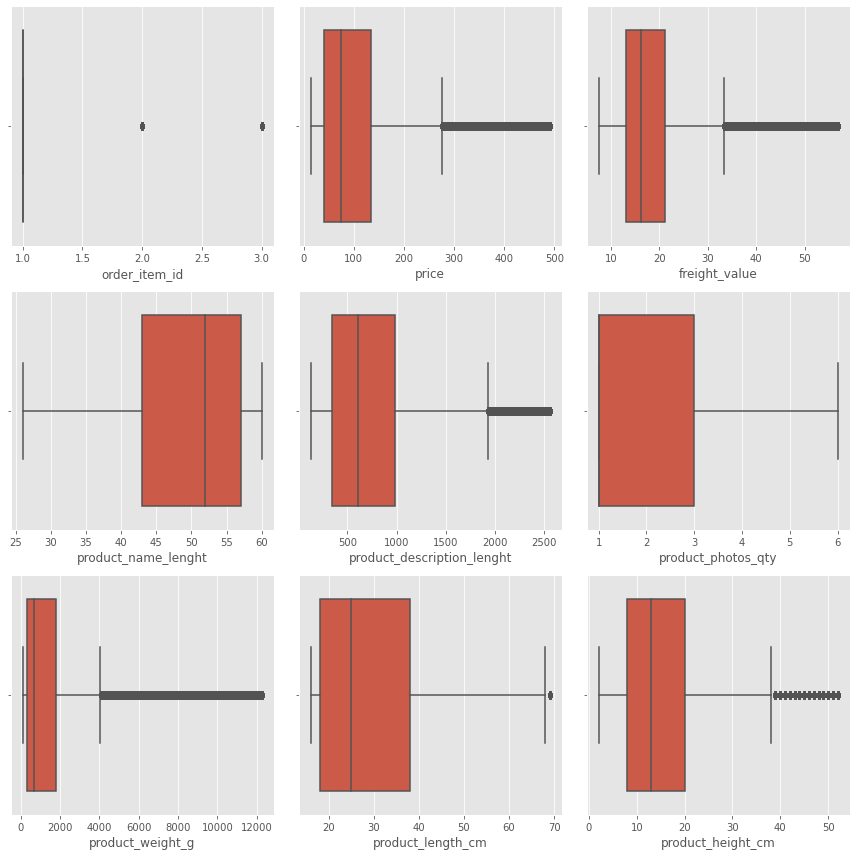

In [197]:
# Plotting boxplot using module
boxplot_multiple_plot(data_delivery_capped[colnames], 3, (12,12))

### Handling Inconsistency

Pada data kali ini dibuat di Brazil, sehingga banyak bahasa potugal. Oleh karena itu akan di mapping menjadi bahasa inggris.

In [198]:
# Backup data using method deepcopy
data_delivery_without_outliers = copy.deepcopy(data_delivery_capped)

In [199]:
# Changing Portuguese to English in the product category name column using the mapping_translation module
data_delivery_without_outliers['product_category_name'].replace(mapping_translation(), inplace=True)

### Analisa Data

In [200]:
# Shows the first 10 records
data_delivery_without_outliers.head(10)

,order_id,product_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,stationery,38.0,316.0,4.0,250.0,51.0,15.0,15.0
5,a4591c265e18cb1dcee52889e2d8acc3,060cb19345d90064d1015407193c233d,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,1.0,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36,auto,49.0,608.0,1.0,7150.0,65.0,10.0,50.0
6,6514b8ad8028c9f2cc2374ded245783f,4520766ec412348b8d4caa5e8a18c464,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,1.0,16090f2ca825584b5a147ab24aa30c86,2017-05-22 13:22:11,59.99,15.17,auto,59.0,956.0,1.0,100.0,16.0,16.0,17.0
7,76c6e866289321a7c93b82b54852dc33,ac1789e492dcd698c5c10b97a671243a,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,1.0,63b9ae557efed31d1f7687917d248a8d,2017-01-27 18:29:09,19.90,16.05,furniture_decor,41.0,432.0,2.0,300.0,35.0,35.0,15.0
8,e69bfb5eb88e0ed6a785585b27e16dbf,9a78fb9862b10749a117f7fc3c31f051,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,1.0,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,office_furniture,45.0,527.0,1.0,9750.0,42.0,41.0,42.0
9,e6ce16cb79ec1d90b1da9085a6118aeb,08574b074924071f4e201e151b152b4e,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,1.0,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.00,30.53,garden_tools,36.0,450.0,1.0,9000.0,42.0,12.0,39.0


Membuat kolom baru seperti `estimated_delivery_time`, `actual_delivery_date`, `delivery_time_delta` dan `delivery_status` untuk memperdalam analisa.

In [201]:
# Create column estimated_delivery_time
data_delivery_without_outliers['estimated_delivery_time'] = data_delivery_without_outliers['order_estimated_delivery_date'] - data_delivery_without_outliers['order_approved_at']

# Create column actual_delivery_date
data_delivery_without_outliers['actual_delivery_date'] = data_delivery_without_outliers['order_delivered_customer_date'] - data_delivery_without_outliers['order_approved_at']

# Calculate the time between the actual and estimated delivery date. If negative was delivered on-time, if positive was delivered late.
data_delivery_without_outliers['delivery_time_delta'] = data_delivery_without_outliers['actual_delivery_date'] - data_delivery_without_outliers['estimated_delivery_time']

# Create column delivery_status, If negative was delivered on-time, if positive was delivered late.
data_delivery_without_outliers['delivery_status'] = data_delivery_without_outliers.apply(lambda x: 'late' if x['order_delivered_customer_date'] > x['order_estimated_delivery_date'] else 'on-time', axis=1)

<AxesSubplot:ylabel='Frequency'>

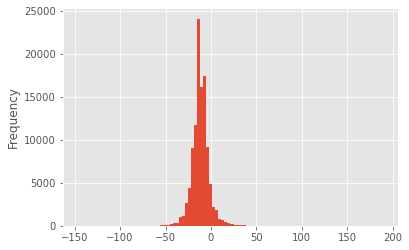

In [202]:
# Show the distribution of delivery_time_delta
(data_delivery_without_outliers['delivery_time_delta'] / (np.timedelta64(1, 'D'))).plot(kind='hist', bins=100)  # type: ignore

In [203]:
# Descriptive statistics on delivery_time_delta
data_delivery_without_outliers.delivery_time_delta.describe()

count                          110173
mean     -12 days +16:03:40.748931227
std        10 days 03:50:28.448127823
min               -147 days +23:36:47
25%                -17 days +16:22:02
50%                -13 days +22:54:56
75%                 -7 days +12:34:29
max                 188 days 23:24:07
Name: delivery_time_delta, dtype: object

<AxesSubplot:ylabel='Frequency'>

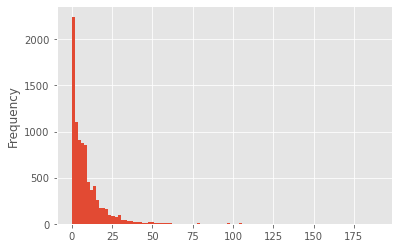

In [204]:
# Show the distribution of delivery_time_delta column where delivery status is late
(data_delivery_without_outliers.delivery_time_delta[data_delivery_without_outliers.delivery_status == 'late'] / (np.timedelta64(1, 'D'))).plot(kind='hist', bins=100)

In [205]:
# Descriptive statistics on delivery_time_delta column where delivery status is late
data_delivery_without_outliers.delivery_time_delta[data_delivery_without_outliers.delivery_status == 'late'].describe()

count                          8713
mean      9 days 10:16:33.647538161
std      13 days 19:19:22.051359281
min                 0 days 00:03:36
25%                 1 days 20:36:03
50%                 5 days 18:37:42
75%                11 days 18:38:49
max               188 days 23:24:07
Name: delivery_time_delta, dtype: object

In [206]:
data_delivery_without_outliers.loc[data_delivery_without_outliers['delivery_time_delta'] / np.timedelta64(1, 'D') > 50]  # type: ignore

,order_id,product_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,estimated_delivery_time,actual_delivery_date,delivery_time_delta,delivery_status
1805,a4efaffc506a395c9cea7402b078c1e5,e4ad97ce352e46bebac92018f6ed976d,2020559b0ae9910898ef57a8159533ab,delivered,2018-01-17 10:50:09,2018-01-17 10:58:33,2018-01-24 12:30:54,2018-05-07 19:25:33,2018-02-23,1.0,3d871de0142ce09b7081e2b9d1733cb1,2018-01-23 10:58:33,89.00,29.02,stationery,51.0,205.0,2.0,7750.0,28.0,52.0,37.0,36 days 13:01:27,110 days 08:27:00,73 days 19:25:33,late
3375,8b7fd198ad184563c231653673e75a7f,a9fa5ce6ccf634df53e924a8ca7099ab,3eddc75fe2314996f68ddcd89ddb5caf,delivered,2017-11-14 10:04:27,2017-11-17 08:47:00,2018-02-26 17:27:15,2018-02-27 18:05:08,2017-11-28,1.0,e09887ca8c7bf8a4621ce481820414ef,2017-11-23 08:47:00,39.99,9.34,furniture_decor,37.0,192.0,2.0,600.0,16.0,40.0,30.0,10 days 15:13:00,102 days 09:18:08,91 days 18:05:08,late
3511,4f39a94d6e474819d898d6df7d394996,15f773b4fea5b2ab681b02620b0c3a95,27a410dccb395b6ce45963874d158352,delivered,2017-04-28 16:28:03,2017-04-29 02:42:51,2017-05-09 14:06:48,2017-09-19 13:54:18,2017-05-30,1.0,82e0a475a88cc9595229d8029273f045,2017-05-05 02:42:51,79.00,19.25,bed_bath_table,52.0,603.0,1.0,750.0,16.0,25.0,15.0,30 days 21:17:09,143 days 11:11:27,112 days 13:54:18,late
3512,4f39a94d6e474819d898d6df7d394996,15f773b4fea5b2ab681b02620b0c3a95,27a410dccb395b6ce45963874d158352,delivered,2017-04-28 16:28:03,2017-04-29 02:42:51,2017-05-09 14:06:48,2017-09-19 13:54:18,2017-05-30,2.0,82e0a475a88cc9595229d8029273f045,2017-05-05 02:42:51,79.00,19.25,bed_bath_table,52.0,603.0,1.0,750.0,16.0,25.0,15.0,30 days 21:17:09,143 days 11:11:27,112 days 13:54:18,late
5115,b31c7dea63bb08f8cdd1ec32514ccf0b,9ca3b0037aaf1552f3d9d29dc471e0d1,2a351c540a0cbdd0d9c266626f6d3acc,delivered,2017-09-26 18:35:35,2017-09-26 18:49:09,2017-09-29 16:23:06,2018-02-05 21:25:43,2017-10-19,1.0,53e4c6e0f4312d4d2107a8c9cddf45cd,2017-10-02 18:49:09,33.00,39.28,furniture_decor,40.0,284.0,3.0,9300.0,25.0,52.0,25.0,22 days 05:10:51,132 days 02:36:34,109 days 21:25:43,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104117,4a580bca631a940ffc9e25c96da01773,c9ea06f7fd4bd778e96031f46f60dfb9,dbd8419d89e2d12f79322167e68e6225,delivered,2017-08-01 19:24:31,2017-08-01 20:10:17,2017-08-02 19:07:36,2017-11-09 18:08:54,2017-08-23,1.0,48436dade18ac8b2bce089ec2a041202,2017-08-07 20:10:17,95.90,16.43,toys,56.0,670.0,1.0,840.0,33.0,13.0,26.0,21 days 03:49:43,99 days 21:58:37,78 days 18:08:54,late
105073,8e25d7ae5953ee779b0bb0a71e434b4c,cef9d587c2c31442c9b95eef617db1f4,cebc1cff5b31ee0ce570b98626a89dc9,delivered,2018-02-24 08:48:54,2018-02-24 09:07:51,2018-03-05 10:22:50,2018-05-14 17:31:47,2018-03-20,1.0,822bad9bc42b51213ba522fe87b7ab5d,2018-03-01 09:07:51,219.00,17.97,telephony,54.0,838.0,2.0,600.0,16.0,2.0,11.0,23 days 14:52:09,79 days 08:23:56,55 days 17:31:47,late
105432,17cc6728043d53cc948551dfbf0a338b,689a9f33ae479ec0d9f68a9b6b0cfcbf,dcfb92c7e6d519560090aeb5bfa03f0c,delivered,2017-11-25 12:14:38,2017-11-25 12:33:04,2017-11-28 18:19:49,2018-04-16 23:26:51,2017-12-27,1.0,95e03ca3d4146e4011985981aeb959b9,2017-12-06 12:31:09,50.00,21.15,furniture_decor,58.0,126.0,1.0,550.0,20.0,27.0,11.0,31 days 11:26:56,142 days 10:53:47,110 days 23:26:51,late
106977,201ebbf7634b25abd400f84d519cf297,cfe6e9c01d0bbb5df9a75f0e3286baa9,a6e1d325e2d80b387efb2a91ae78568b,delivered,2017-06-11 21:27:02,2017-06-11 21:35:21,2017-06-19 14:42:03,2017-09-19 14:02:52,2017-07-13,1.0,1d8dbc4f32378d715c717c1c1fc57bae,2017-06-19 21:35:21,110.00,29.17,baby,47.0,224.0,2.0,1200.0,69.0,15.0,50.0,31 days 02:24:39,99 days 16:27:31,68 days 1

<AxesSubplot:ylabel='Frequency'>

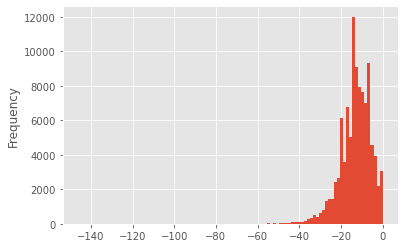

In [207]:
# Show the distribution of delivery_time_delta column where delivery status is on-time
(data_delivery_without_outliers.delivery_time_delta[data_delivery_without_outliers.delivery_status == 'on-time'] / (np.timedelta64(1, 'D'))).plot(kind='hist', bins=100)

In [208]:
# Descriptive statistics on delivery_time_delta column where delivery status is on-time
data_delivery_without_outliers.delivery_time_delta[data_delivery_without_outliers.delivery_status == 'on-time'].describe()

count                          101460
mean     -14 days +21:16:35.510753007
std         7 days 10:51:45.492103763
min               -147 days +23:36:47
25%                -18 days +20:49:01
50%                -13 days +15:27:04
75%          -9 days +22:46:55.250000
max                 -1 days +23:59:55
Name: delivery_time_delta, dtype: object

Lama Waktu pesanan di approve

<AxesSubplot:ylabel='Frequency'>

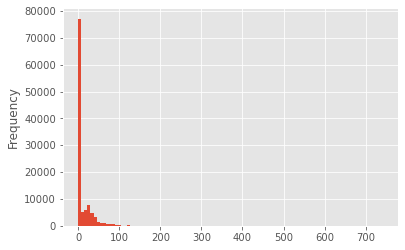

In [209]:
((data_delivery_without_outliers['order_approved_at'] - data_delivery_without_outliers['order_purchase_timestamp']) / np.timedelta64(1, 'h')).plot(kind='hist', bins=100)

In [210]:
((data_delivery_without_outliers['order_approved_at'] - data_delivery_without_outliers['order_purchase_timestamp']) / np.timedelta64(1, 'h')).describe()

count    110173.000000
mean         10.519036
std          20.987026
min           0.000000
25%           0.216389
50%           0.350278
75%          15.165556
max         741.443611
dtype: float64

Lama waktu pesanan di proses oleh kurir sejak di approve

<AxesSubplot:ylabel='Frequency'>

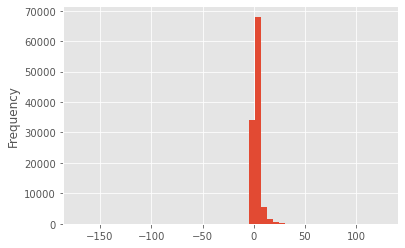

In [211]:
((data_delivery_without_outliers['order_delivered_carrier_date'] - data_delivery_without_outliers['order_approved_at']) / np.timedelta64(1, 'D')).plot(kind='hist', bins=50)

In [212]:
((data_delivery_without_outliers['order_delivered_carrier_date'] - data_delivery_without_outliers['order_approved_at']) / np.timedelta64(1, 'D')).describe()

count    110173.000000
mean          2.845234
std           3.579416
min        -171.219005
25%           0.881759
50%           1.835243
75%           3.633461
max         125.762569
dtype: float64

#### Proporsi delivery status

In [213]:
# Create new dataframe
pro_delivery_status = pd.DataFrame(data_delivery_without_outliers.delivery_status.value_counts()).reset_index()

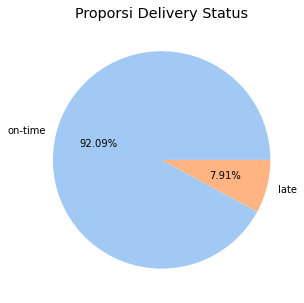

In [214]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(5,5))

#define Seaborn color palette to use
colors = sns.color_palette('pastel')

# plotting data on chart
ax.pie(pro_delivery_status['delivery_status'], labels=pro_delivery_status['index'], colors=colors, autopct='%.2f%%')  # type: ignore

plt.title("Proporsi Delivery Status")

plt.show()

#### Waktu penerimaan produk kepada pelanggan

##### Send by Courier

In [215]:
# Drop unnecessary column
data_carrier = data_delivery_without_outliers.drop(['order_status', 'order_item_id', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1).copy()

In [216]:
# Extracting attributes for estimated deliverd time - Day and Day of Week
data_carrier['delivered_time_day'] = data_carrier['order_delivered_carrier_date'].apply(lambda x: x.day)
data_carrier['delivered_time_dayofweek'] = data_carrier['order_delivered_carrier_date'].apply(lambda x: x.dayofweek)
data_carrier['delivered_time_dayofweek_name'] = data_carrier['order_delivered_carrier_date'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for estimated delivered time - Hour and Time of the Day
data_carrier['delivered_time_hour'] = data_carrier['order_delivered_carrier_date'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
data_carrier['delivered_time_timeday'] = pd.cut(data_carrier['delivered_time_hour'], hours_bins, labels=hours_labels)

# Show new dataframe
data_carrier.head()

,order_id,product_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,shipping_limit_date,price,freight_value,product_category_name,estimated_delivery_time,actual_delivery_date,delivery_time_delta,delivery_status,delivered_time_day,delivered_time_dayofweek,delivered_time_dayofweek_name,delivered_time_hour,delivered_time_timeday
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,15 days 12:52:45,8 days 10:17:58,-8 days +21:25:13,on-time,4,2,Wed,19,Night
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,17 days 20:35:33,12 days 12:03:18,-6 days +15:27:45,on-time,26,3,Thu,14,Afternoon
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,auto,26 days 15:04:37,9 days 09:11:06,-18 days +18:06:29,on-time,8,2,Wed,13,Afternoon
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,26 days 04:14:01,13 days 04:42:43,-13 days +00:28:42,on-time,22,2,Wed,13,Afternoon
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,stationery,12 days 01:39:31,2 days 19:56:33,-10 days +18:17:02,on-time,14,2,Wed,19,Night


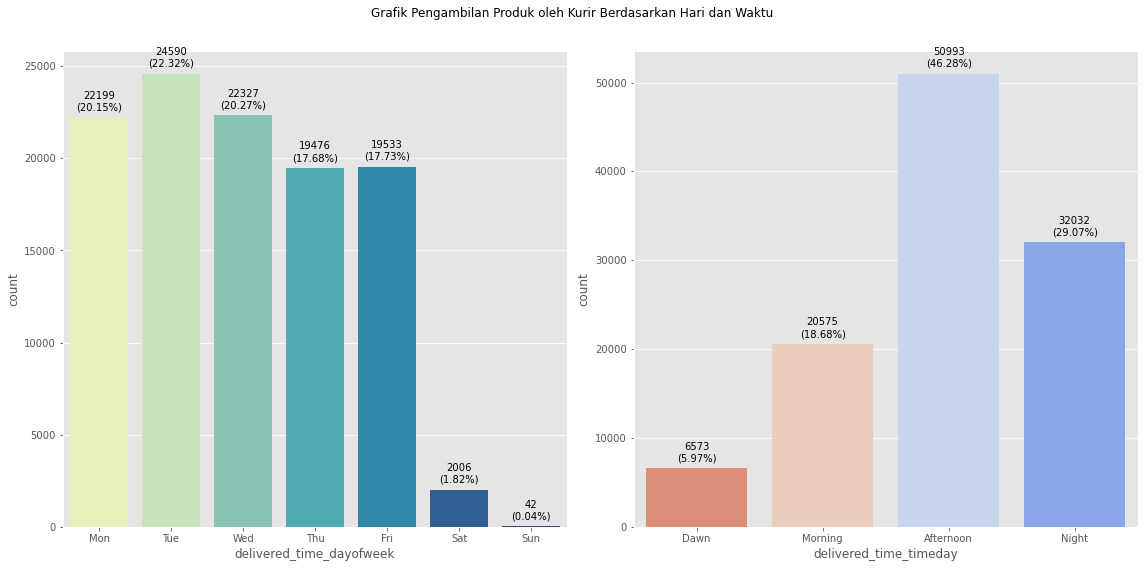

In [217]:
# Plotting day and time using module
subplots_dayname_timeday(data_carrier, 'delivered_time_dayofweek', 'delivered_time_timeday', 'Grafik Pengambilan Produk oleh Kurir Berdasarkan Hari dan Waktu')

In [218]:
# Grupby pick-up time by day and hour
delivery_pickup = data_carrier.groupby(['delivered_time_dayofweek_name', 'delivered_time_hour']).count()['order_id'].unstack()

# Fill nan value with 0
delivery_pickup = delivery_pickup.fillna(0)

# Change dtype with int
delivery_pickup = delivery_pickup.astype(int)

In [219]:
# Show the data
display(delivery_pickup)

delivered_time_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
delivered_time_dayofweek_name,,,,,,,,,,,,,,,,,,,,,,,,
Fri,540,277,132,52,21,48,88,172,347,447,666,812,1181,1511,2201,1636,1159,1205,1448,1596,1349,1042,949,654
Mon,0,5,14,16,10,20,176,179,377,596,668,961,1176,1770,2572,2276,1364,1256,1628,1976,1622,1431,1152,954
Sat,493,401,116,34,22,10,19,50,119,99,51,55,79,86,93,91,82,53,39,7,3,2,2,0
Sun,0,1,1,4,2,0,1,0,0,2,6,2,2,4,8,2,2,3,0,0,0,1,0,1
Thu,531,222,101,51,31,76,157,220,390,544,591,815,1121,1606,2159,1728,1116,1106,1331,1481,1347,1098,886,768
Tue,673,343,185,85,65,85,184,375,525,567,811,984,1303,1878,2571,2208,1547,1385,1818,1823,1484,1378,1331,982
Wed,571,264,127,68,35,63,153,186,419,591,787,1057,1242,1692,2244,1959,1224,1291,1641,1811,1745,1339,998,820


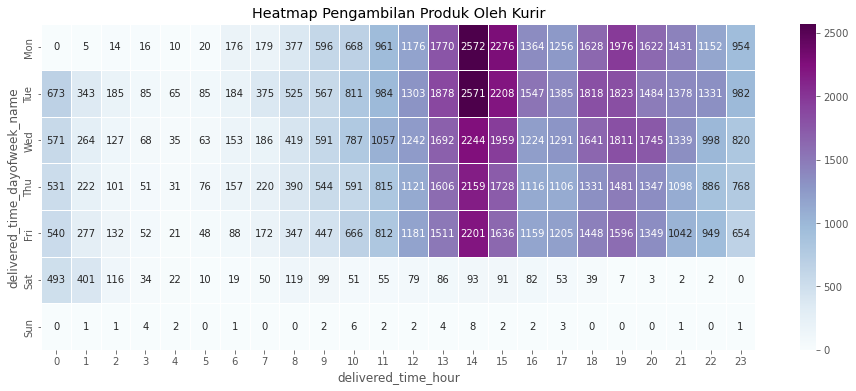

In [220]:
# Heatmap pick-up by courier by hours
plt.figure(figsize=(16,6))
sns.heatmap(delivery_pickup.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
            cmap="BuPu", annot=True, fmt="d", linewidths=0.5)  # type: ignore
plt.title("Heatmap Pengambilan Produk Oleh Kurir")
plt.show()

##### Actual Delivery

In [221]:
# Drop unnecessary column
data_actual_delivery = data_delivery_without_outliers.drop(['order_status', 'order_item_id', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1).copy()

In [222]:
# Extracting attributes for actual deliverd time - Day and Day of Week
data_actual_delivery['delivered_time_day'] = data_actual_delivery['order_delivered_customer_date'].apply(lambda x: x.day)
data_actual_delivery['delivered_time_dayofweek'] = data_actual_delivery['order_delivered_customer_date'].apply(lambda x: x.dayofweek)
data_actual_delivery['delivered_time_dayofweek_name'] = data_actual_delivery['order_delivered_customer_date'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for actual delivered time - Hour and Time of the Day
data_actual_delivery['delivered_time_hour'] = data_actual_delivery['order_delivered_customer_date'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
data_actual_delivery['delivered_time_timeday'] = pd.cut(data_actual_delivery['delivered_time_hour'], hours_bins, labels=hours_labels)

# Show new dataframe
data_actual_delivery.head()

,order_id,product_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,shipping_limit_date,price,freight_value,product_category_name,estimated_delivery_time,actual_delivery_date,delivery_time_delta,delivery_status,delivered_time_day,delivered_time_dayofweek,delivered_time_dayofweek_name,delivered_time_hour,delivered_time_timeday
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,15 days 12:52:45,8 days 10:17:58,-8 days +21:25:13,on-time,10,1,Tue,21,Night
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,17 days 20:35:33,12 days 12:03:18,-6 days +15:27:45,on-time,7,1,Tue,15,Afternoon
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,auto,26 days 15:04:37,9 days 09:11:06,-18 days +18:06:29,on-time,17,4,Fri,18,Afternoon
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,26 days 04:14:01,13 days 04:42:43,-13 days +00:28:42,on-time,2,5,Sat,0,Dawn
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,stationery,12 days 01:39:31,2 days 19:56:33,-10 days +18:17:02,on-time,16,4,Fri,18,Afternoon


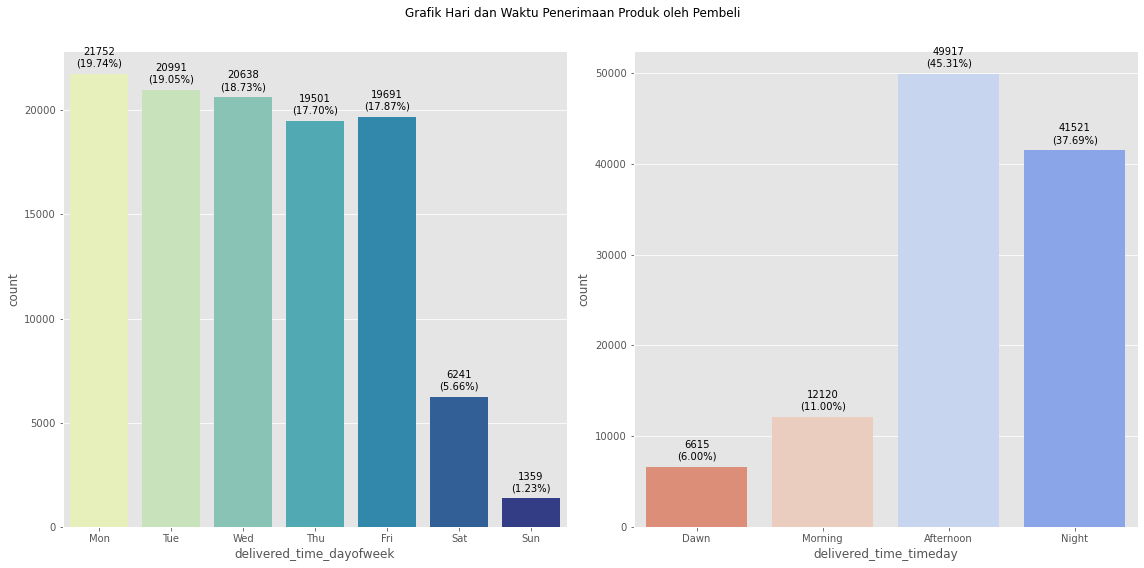

In [223]:
# Plotting day and time using module
subplots_dayname_timeday(data_actual_delivery, 'delivered_time_dayofweek', 'delivered_time_timeday', 'Grafik Hari dan Waktu Penerimaan Produk oleh Pembeli')

In [224]:
# Grupby pick-up time by day and hour
delivery_time = data_actual_delivery.groupby(['delivered_time_dayofweek_name', 'delivered_time_hour']).count()['order_id'].unstack()

# Fill nan with 0
delivery_time = delivery_time.fillna(0)

# Change dtypes with int
delivery_time = delivery_time.astype(int)

In [225]:
# Show the data
delivery_time.head()

delivered_time_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
delivered_time_dayofweek_name,,,,,,,,,,,,,,,,,,,,,,,,
Fri,610,316,162,62,31,34,57,83,133,209,392,465,692,889,1055,1259,1496,1907,1985,2002,2035,1584,1280,953
Mon,0,3,6,3,10,22,43,94,195,263,382,596,752,1010,1315,1586,1794,2093,2482,2340,2267,1891,1482,1123
Sat,651,334,135,55,26,44,40,46,78,122,250,380,572,554,640,620,593,474,283,176,109,36,14,9
Sun,6,4,3,3,4,7,9,8,22,25,61,76,122,147,169,161,174,115,108,71,43,17,4,0
Thu,591,320,152,58,34,40,52,76,150,258,332,447,671,870,1025,1339,1661,1787,1942,1902,1889,1675,1306,924


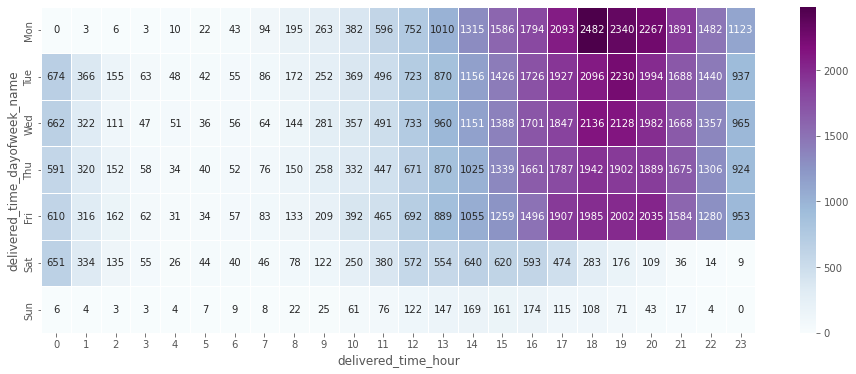

In [226]:
# Heatmap actual delivered time by hours
plt.figure(figsize=(16,6))
sns.heatmap(delivery_time.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
            cmap="BuPu", annot=True, fmt="d", linewidths=0.5)
plt.show("Heatmap Actual Delivered Time by Hour")
plt.show()

#### Kategori produk apa saja yang paling banyak mengalami keterlambatan

In [227]:
data_product_delivery_status = data_delivery_without_outliers.groupby(['product_category_name', 'delivery_status'], as_index=False).agg(
    n_orders = ('delivery_status', 'count'),
    median_weight_g = ('product_weight_g', np.median)
).copy()

In [228]:
pivot_delivery_status_by_product = pd.pivot_table(data_product_delivery_status, values=['n_orders', 'median_weight_g'], index='product_category_name', columns='delivery_status', fill_value=0)

In [229]:
display(pivot_delivery_status_by_product)

median_weight_g         n_orders        
delivery_status                       late on-time     late on-time
product_category_name                                              
agro_industry_and_commerce          2700.0  2650.0        9     197
air_conditioning                    5700.0  2800.0       11     278
art                                 1700.0  1700.0       15     182
arts_and_craftmanship               2550.0   550.0        2      22
audio                                425.0   343.0       46     316
...                                    ...     ...      ...     ...
stationery                           650.0  1000.0      198    2268
tablets_printing_image               283.0   300.0        6      77
telephony                            250.0   225.0      369    4059
toys                                1100.0   750.0      299    3730
watches_gifts                        350.0   346.0      485    5372

[73 rows x 4 columns]

In [230]:
pivot_delivery_status_by_product['n_orders'].sort_values('late', ascending=False).head(10)['late']

product_category_name
bed_bath_table           1064
health_beauty             857
furniture_decor           687
sports_leisure            625
computers_accessories     594
watches_gifts             485
housewares                441
telephony                 369
auto                      343
garden_tools              340
Name: late, dtype: int64

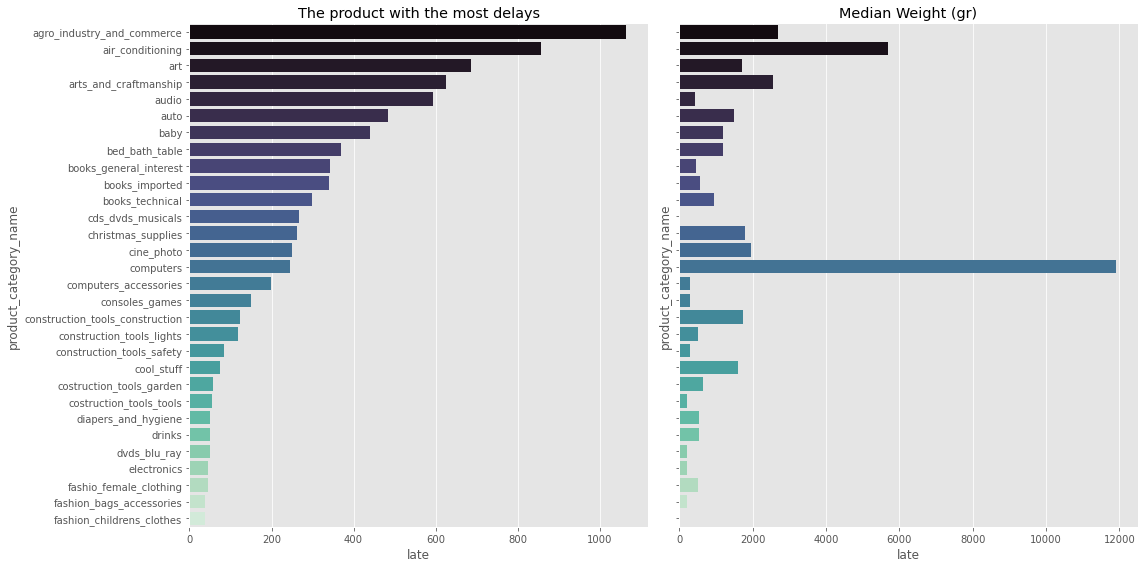

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)

# colors = sns.color_palette("dark:#5A9_r", as_cmap=True)

sns.barplot(
    data=pivot_delivery_status_by_product['n_orders'].sort_values('late', ascending=False),
    x = pivot_delivery_status_by_product['n_orders'].sort_values('late', ascending=False).head(30)['late'],
    y = pivot_delivery_status_by_product['n_orders'].sort_values('late', ascending=False).head(30).index,
    palette = "mako",
    ax=ax[0]
)

ax[0].set_title('The product with the most delays')

sns.barplot(
    data=pivot_delivery_status_by_product['median_weight_g'],
    x = pivot_delivery_status_by_product['median_weight_g']['late'].head(30),
    y = pivot_delivery_status_by_product['median_weight_g'].head(30).index,
    palette = "mako",
    ax=ax[1]   
)

ax[1].set_title("Median Weight (gr)")

fig.tight_layout()
plt.show()

## Seller

### Akses Dataset

In [232]:
querry_3 = """
SELECT *
FROM olist_sellers_dataset;
"""

In [233]:
# Create dataframe seller using querry_3
seller = pd.read_sql(querry_3, conn)
seller.head()

,index,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [234]:
# Drop column index from dataframe seller
seller.drop('index', axis=1, inplace=True)

# Show info from seller
seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [235]:
# Merge dataframe data_delivery_without_outliers dengan  dataframe seller menggunakn left join
data_seller = data_delivery_without_outliers.merge(seller, how='left', on='seller_id').copy()
data_seller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110173 entries, 0 to 110172
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       110173 non-null  object         
 1   product_id                     110173 non-null  object         
 2   customer_id                    110173 non-null  object         
 3   order_status                   110173 non-null  object         
 4   order_purchase_timestamp       110173 non-null  datetime64[ns] 
 5   order_approved_at              110173 non-null  datetime64[ns] 
 6   order_delivered_carrier_date   110173 non-null  datetime64[ns] 
 7   order_delivered_customer_date  110173 non-null  datetime64[ns] 
 8   order_estimated_delivery_date  110173 non-null  datetime64[ns] 
 9   order_item_id                  110173 non-null  float64        
 10  seller_id                      110173 non-null  object  

### Missing Value

#### Check Missing Value

In [236]:
# Check missing value menggunakan module check_missing_value
check_missing_value(data_seller)

,NaN_count,NaN_percentage


### Duplicated

#### Check Column Duplicate

In [237]:
# Check column duplicated
data_carrier.T.duplicated(keep=False)

order_id                         False
product_id                       False
customer_id                      False
order_purchase_timestamp         False
order_approved_at                False
order_delivered_carrier_date     False
order_delivered_customer_date    False
order_estimated_delivery_date    False
seller_id                        False
shipping_limit_date              False
price                            False
freight_value                    False
product_category_name            False
estimated_delivery_time          False
actual_delivery_date             False
delivery_time_delta              False
delivery_status                  False
delivered_time_day               False
delivered_time_dayofweek         False
delivered_time_dayofweek_name    False
delivered_time_hour              False
delivered_time_timeday           False
dtype: bool

### Filter datatypes

In [238]:
# int64 columns
int_columns = [data for data in data_seller.columns if data_seller.dtypes[data] == np.int64]

# float64 columns
float_columns = [data for data in data_seller.columns if data_seller.dtypes[data] == np.float64]

# categorical columns
obj_columns = [data for data in data_seller.columns if data_seller.dtypes[data] == object]

# datetime columns
datetime_columns = [data for data in data_seller.columns if is_datetime(data_seller[data])]

# timedeltas columns
timedelta_columns = [data for data in data_seller.columns if is_timedelta(data_seller[data])]

### Outliers

#### Check Outliers

In [239]:
# Check number of columns
len(data_seller[int_columns+float_columns].columns)

11

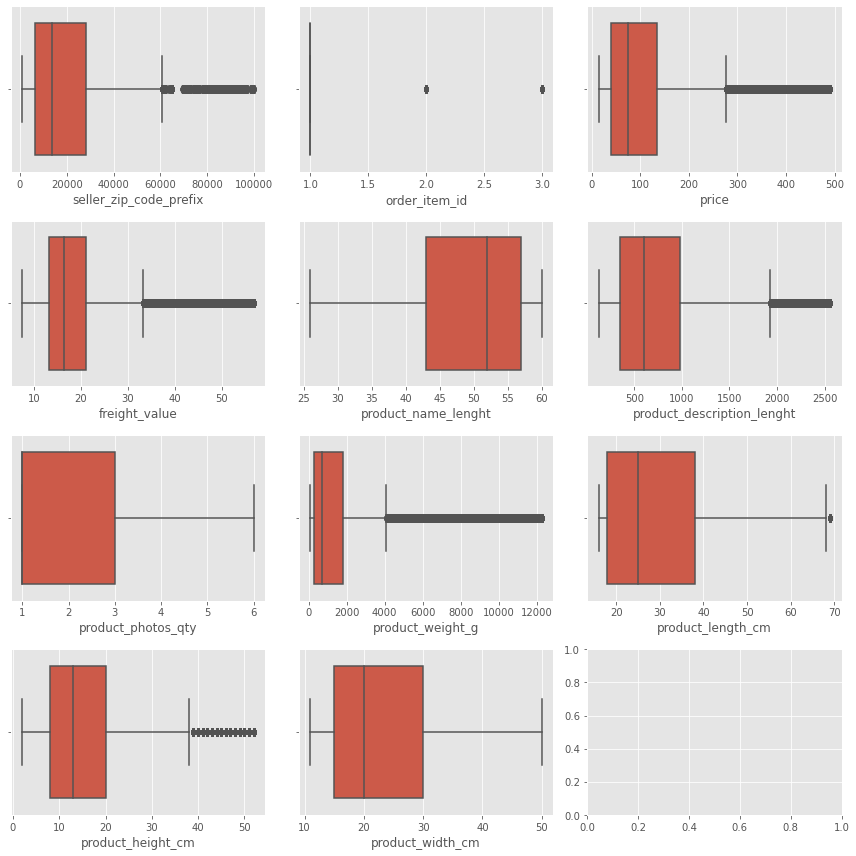

In [240]:
# Plot boxplot using module boxplot_multiple_plot
boxplot_multiple_plot(data_seller[int_columns+float_columns], 4, (12,12))

### Analisa Data

In [241]:
data_seller.head(10)

,order_id,product_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,estimated_delivery_time,actual_delivery_date,delivery_time_delta,delivery_status,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,15 days 12:52:45,8 days 10:17:58,-8 days +21:25:13,on-time,9350,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0,17 days 20:35:33,12 days 12:03:18,-6 days +15:27:45,on-time,31570,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0,26 days 15:04:37,9 days 09:11:06,-18 days +18:06:29,on-time,14840,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,26 days 04:14:01,13 days 04:42:43,-13 days +00:28:42,on-time,31842,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,stationery,38.0,316.0,4.0,250.0,51.0,15.0,15.0,12 days 01:39:31,2 days 19:56:33,-10 days +18:17:02,on-time,8752,mogi das cruzes,SP
5,a4591c265e18cb1dcee52889e2d8acc3,060cb19345d90064d1015407193c233d,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,1.0,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36,auto,49.0,608.0,1.0,7150.0,65.0,10.0,50.0,22 days 01:49:47,16 days 12:47:42,-6 days +10:57:55,on-time,7112,guarulhos,SP
6,6514b8ad8028c9f2cc2374ded245783f,4520766ec412348b8d4caa5e8a18c464,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,1.0,16090f2ca825584b5a147ab24aa30c86,2017-05-22 13:22:11,59.99,15.17,auto,59.0,956.0,1.0,100.0,16.0,16.0,17.0,21 days 10:37:49,9 days 23:33:40,-12 days +12:55:51,on-time,12940,atibaia,SP
7,76c6e866289321a7c93b82b54852dc33,ac1789e492dcd698c5c10b97a671243a,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,1.0,63b9ae557efed31d1f7687917d248a8d,2017-01-27 18:29:09,19.90,16.05,furniture_decor,41.0,432.0,2.0,300.0,35.0,35.0,15.0,39 days 21:09:13,8 days 11:17:23,-32 days +14:08:10,on-time,13720,sao jose do rio pardo,SP
8,e69bfb5eb88e0ed6a785585b27e16dbf,9a78fb9862b10749a117f7fc3c31f051,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,1.0,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,office_furniture,45.0,

In [242]:
data_statte_city = pd.crosstab([data_seller.seller_state , data_seller.seller_city], data_seller.delivery_status, margins=True)

In [243]:
data_statte_city.reset_index()

delivery_status,seller_state,seller_city,late,on-time,All
0,AM,manaus,2,1,3
1,BA,arraial d'ajuda (porto seguro),4,24,28
2,BA,bahia,0,5,5
3,BA,barro alto,0,1,1
4,BA,eunapolis,0,14,14
...,...,...,...,...,...
615,SP,vicente de carvalho,12,208,220
616,SP,volta redonda,10,137,147
617,SP,votorantim,32,225,257
618,SP,votuporanga,14,120,134
